<div style="text-align: center; font-size: 30px; font-weight: bold;">
Movement Prediction
<br> -------------- <br> 
Many pipelines
<br> -------------- <br>
Grid Search
</div>

## Introduction

This notebook aims to gather the results of the grid search for the best pipelines for both movement and movement intention prediction. The hyperparameters search has been performed on the ISAE Supaero's HPC cluster. All the training environnment and script can be found in the [`src/training/RIEMANN_many_pipelines_grid_search/`](./../../src/training/RIEMANN_many_pipelines_grid_search/). The results for each grid search are stored in the `results/` folder next to this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
# Names and paths
RESULT_PATH = './../../src/training/many_pipelines_grid_search/results/'
NAME_RESULTS = 'many_pipelines_MVT_search_preproc'
SAVE_PATH = './results/'
NAME_SAVE = 'many_pipelines_MVT_search_preproc'

In [3]:
# Gather results
def gather_results(path, name, save_path, name_save, verbose=False):
    files = [f for f in os.listdir(path) if f.startswith(name) and f.endswith('.csv')]
    files = [os.path.join(path, f) for f in files]
    dfs = []
    if verbose:
        print(f'Gathering {len(files)} files')
        print(f'files: {files}')
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)
        if verbose:
            print(f'File {file} has shape {df.shape}')
    result_df = pd.concat(dfs, ignore_index=True)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    result_df.to_csv(os.path.join(save_path, name_save + '.csv'), index=False)
    return result_df

In [4]:
# Load results
def boxplot_results(result_df, parameters, scores=['score_A', 'score_B', 'score_C', 'score_X']):
    fig, ax = plt.subplots(len(scores), len(parameters), figsize=(15, 20))
    fig.suptitle('Hyperparameter tuning')

    for i, score in enumerate(scores):
        for j, param in enumerate(parameters):
            sns.boxplot(x=param, y=score, data=result_df, ax=ax[i, j])
            ax[i, j].set_title(score + ' ' + param)

    plt.tight_layout()
    plt.show()

In [5]:
def maxplot_all_results(result_df, param, figsize=(15, 10), mean_ABC=False):
    fig, ax = plt.subplots(1, len(param), figsize=figsize)
    result_df['mean_ABC'] = result_df[['score_A', 'score_B', 'score_C']].mean(axis=1)

    for p in param:
        max_score_A = result_df.groupby(p)['score_A'].max()
        max_score_B = result_df.groupby(p)['score_B'].max()
        max_score_C = result_df.groupby(p)['score_C'].max()
        max_score_X = result_df.groupby(p)['score_X'].max()
        if mean_ABC:
            max_score_ABC = result_df.groupby(p)['mean_ABC'].max()
            max_score_ABC = max_score_ABC.reset_index()

        max_score_A = max_score_A.reset_index()
        max_score_B = max_score_B.reset_index()
        max_score_C = max_score_C.reset_index()
        max_score_X = max_score_X.reset_index()
        
        if len(param) == 1:
            ax.plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
            ax.plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
            ax.plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
            ax.plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
            if mean_ABC:
                ax.plot(max_score_ABC[p], max_score_ABC['mean_ABC'], label='mean_ABC', marker='x')
            ax.set_title(p)
        else:
            ax[param.index(p)].plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
            ax[param.index(p)].plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
            ax[param.index(p)].plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
            ax[param.index(p)].plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
            if mean_ABC:
                ax[param.index(p)].plot(max_score_ABC[p], max_score_ABC['mean_ABC'], label='mean_ABC', marker='x')
            ax[param.index(p)].set_title(p)

    plt.legend()
    plt.show()



In [6]:
def maxplot_all_results(result_df, param):
    fig, ax = plt.subplots(1, len(param), figsize=(15, 10))

    for p in param:
        max_score_A = result_df.groupby(p)['score_A'].max()
        max_score_B = result_df.groupby(p)['score_B'].max()
        max_score_C = result_df.groupby(p)['score_C'].max()
        max_score_X = result_df.groupby(p)['score_X'].max()

        max_score_A = max_score_A.reset_index()
        max_score_B = max_score_B.reset_index()
        max_score_C = max_score_C.reset_index()
        max_score_X = max_score_X.reset_index()

        ax[param.index(p)].plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
        ax[param.index(p)].plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
        ax[param.index(p)].plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
        ax[param.index(p)].plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
        ax[param.index(p)].set_title(p)

        
    plt.legend()
    plt.show()



In [7]:
def rebase_results(result_df_v6):
    result_df_v6['pipeline_name'] = result_df_v6['pipeline'].apply(lambda x: x.split("steps=[('")[1].split("'")[0])
    result_df_v6['model'] = result_df_v6['pipeline'].apply(lambda x: x.split("clf', ")[1].split("()")[0])
    result_df_v6.loc[result_df_v6['pipeline_name'] == 'cov', 'pipeline_name'] = 'riemann'
    result_df_v6.loc[result_df_v6['pipeline_name'] == 'fd', 'pipeline_name'] = 'MLP'
    result_df_v6.loc[result_df_v6['model'] == 'LogisticRegression', 'model'] = 'LR'
    result_df_v6.loc[result_df_v6['model'] == 'RandomForestClassifier', 'model'] = 'RandForest'
    result_df_v6.loc[result_df_v6['model'] == 'AdaBoostClassifier', 'model'] = 'AdaBoost'
    result_df_v6.loc[result_df_v6['model'] == 'LinearDiscriminantAnalysis', 'model'] = 'LDA'
    result_df_v6['model'] = result_df_v6['model'].apply(lambda x: 'MLP' if 'MLP' in x else x)
    result_df_v6['pipeline_step_1'] = result_df_v6['pipeline'].apply(lambda x: x.split("steps=[('")[1].split("'")[0])
    result_df_v6['pipeline_step_2'] = result_df_v6['pipeline'].apply(lambda x: x.split("('")[2].split("'")[0] if len(x.split("('")) > 2 and x.split("('")[2].split("'")[0] != 'clf' else 'no_step')
    result_df_v6['pipeline_step_3'] = result_df_v6['pipeline'].apply(lambda x: x.split("('")[3].split("'")[0] if len(x.split("('")) > 3 and x.split("('")[3].split("'")[0] != 'clf' else 'no_step')
    result_df_v6['pipeline_name'] = result_df_v6['pipeline_step_1'] + '_' + result_df_v6['pipeline_step_2'] + '_' + result_df_v6['pipeline_step_3']
    result_df_v6['pipeline_name'] = result_df_v6['pipeline_name'].apply(lambda x: x.replace('_no_step', ''))
    result_df_v6[['pipeline_step_1', 'pipeline_step_2', 'pipeline_step_3', 'model', 'pipeline_name']]
    result_df_v6['pipeline_name'] = result_df_v6['pipeline_name'].apply(lambda x: x.replace('fd', 'vec'))
    result_df_v6['mean_score'] = result_df_v6[['score_A', 'score_B', 'score_C', 'score_X']].mean(axis=1)
    result_df_v6['mean_ABC'] = result_df_v6[['score_A', 'score_B', 'score_C']].mean(axis=1)
    result_df_v6['pipeline_name'] = result_df_v6['pipeline_name'].apply(lambda x: x.replace('_vec', ''))
    result_df_v6['pipeline_name'] = result_df_v6['pipeline_name'].apply(lambda x: x.replace('wavelet', 'wvlt'))

In [8]:
def print_preproc(result_df_v1):
    epochs_tmin = result_df_v1['EPOCHS_TMIN'].unique()
    epochs_length = result_df_v1['EPOCHS_LENGTH'].unique()
    epochs_empty_from_mvt_tmin = result_df_v1['EPOCHS_EMPTY_FROM_MVT_TMIN'].unique()
    epochs_intention_from_mvt_tmin = result_df_v1['EPOCHS_INTENTION_FROM_MVT_TMIN'].unique() if 'EPOCHS_INTENTION_FROM_MVT_TMIN' in result_df_v1.columns else None
    fmin = result_df_v1['FMIN'].unique()
    fmax = result_df_v1['FMAX'].unique()

    # print all preprocessing parameters
    print(f'epochs_tmin: {epochs_tmin}')
    print(f'epochs_length: {epochs_length}')
    print(f'epochs_empty_from_mvt_tmin: {epochs_empty_from_mvt_tmin}')
    print(f'epochs_intention_from_mvt_tmin: {epochs_intention_from_mvt_tmin}')
    print(f'fmin: {fmin}')
    print(f'fmax: {fmax}')

In [9]:
def print_pipelines_params(result_df_v1):
    pipeline_name = result_df_v1['pipeline_name'].unique()
    model = result_df_v1['model'].unique()
    pipeline_step_1 = result_df_v1['pipeline_step_1'].unique()
    pipeline_step_2 = result_df_v1['pipeline_step_2'].unique()
    pipeline_step_3 = result_df_v1['pipeline_step_3'].unique()
    
    # print all preprocessing parameters
    print(f'pipeline_name: {pipeline_name}')
    print(f'model: {model}')
    print(f'pipeline_step_1: {pipeline_step_1}')
    print(f'pipeline_step_2: {pipeline_step_2}')
    print(f'pipeline_step_3: {pipeline_step_3}')
    
    step_param = []
    for name in result_df_v1.columns:
        if '__' in name:
            step_param.append(result_df_v1[name].unique())
            print(f'{name}: {step_param[-1]}')
    

## Grid Search 1, 2, 3 : CSP, Riemann, Xdawn, Vec (=flatten) on optimized preprocessing (movement prediction)

### Downloading the results

In [10]:
Version = 'V1'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v1 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save, verbose=True)
rebase_results(result_df_v1)
result_df_v1['version'] = 'v1'

Gathering 8 files
files: ['./../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_1.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_2.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_3.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_4.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_5.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_6.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_7.csv', './../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_preproc_V1_node_8.csv']
File ./../../src/training/many_pipelines_grid_search/results/V1/many_pipelines_MVT_search_prep

In [11]:
Version = 'V2'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v2 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save, verbose=True)
rebase_results(result_df_v2)
result_df_v2['version'] = 'v2'

Gathering 4 files
files: ['./../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_1.csv', './../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_2.csv', './../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_3.csv', './../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_4.csv']
File ./../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_1.csv has shape (1, 29)
File ./../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_2.csv has shape (1, 28)
File ./../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_3.csv has shape (1, 28)
File ./../../src/training/many_pipelines_grid_search/results/V2/many_pipelines_MVT_search_preproc_V2_node_4.csv has shape (1, 28)


In [12]:
Version = 'V3'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v3 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save, verbose=True)
rebase_results(result_df_v3)
result_df_v3['version'] = 'v3'

Gathering 2 files
files: ['./../../src/training/many_pipelines_grid_search/results/V3/many_pipelines_MVT_search_preproc_V3_node_1.csv', './../../src/training/many_pipelines_grid_search/results/V3/many_pipelines_MVT_search_preproc_V3_node_2.csv']
File ./../../src/training/many_pipelines_grid_search/results/V3/many_pipelines_MVT_search_preproc_V3_node_1.csv has shape (1, 28)
File ./../../src/training/many_pipelines_grid_search/results/V3/many_pipelines_MVT_search_preproc_V3_node_2.csv has shape (1, 28)


In [13]:
# Concatenate results
result_df_v123 = pd.concat([result_df_v1, result_df_v2, result_df_v3], ignore_index=True)
# Save results
result_df_v123.to_csv(os.path.join(SAVE_PATH, name_save + '.csv'), index=False)

In [14]:
result_df_v123 = pd.read_csv(SAVE_PATH + name_save + ".csv")

### Preprocessing parameters grid

In [15]:
print_preproc(result_df_v1)

epochs_tmin: [-0.75]
epochs_length: [1.7]
epochs_empty_from_mvt_tmin: [-6]
epochs_intention_from_mvt_tmin: None
fmin: [9]
fmax: [30]


### Pipeline parameters grid

In [16]:
print_pipelines_params(result_df_v1)

pipeline_name: ['cov_ts_ss' 'csp' 'vec_ss' 'xdawn_ss']
model: ['RandForest' 'SVC' 'AdaBoost' 'LDA']
pipeline_step_1: ['cov' 'csp' 'vec' 'xdawn']
pipeline_step_2: ['ts' 'no_step' 'ss' 'vec']
pipeline_step_3: ['ss' 'no_step']
cov__estimator: ['oas' nan]


### Plots

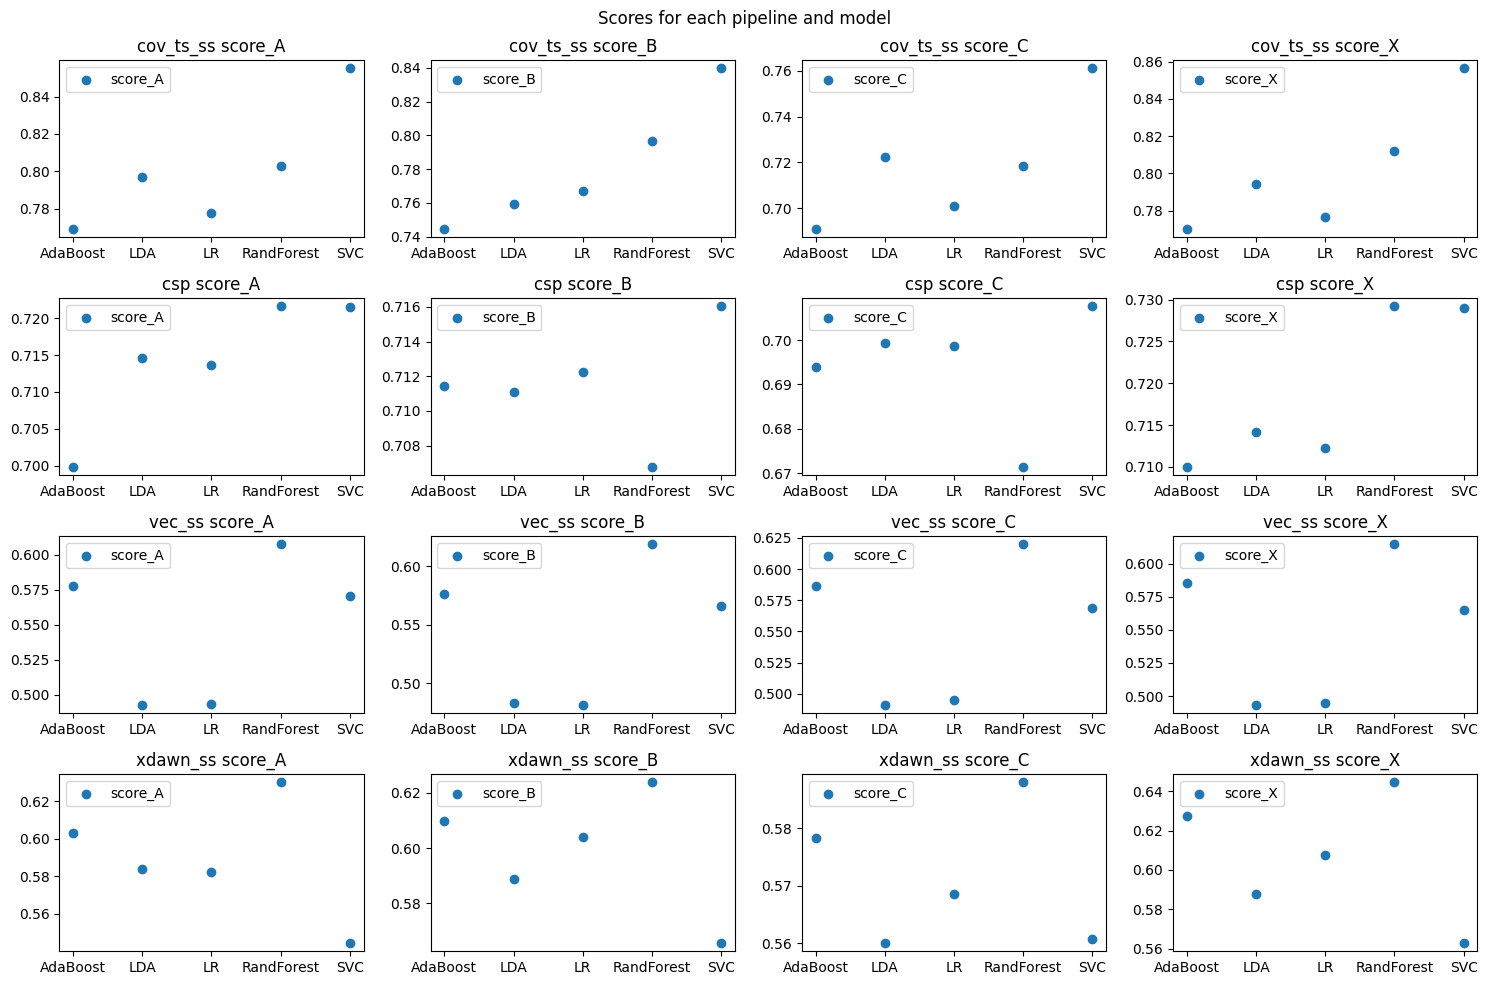

In [17]:
pipelines = result_df_v123['pipeline_name'].unique()
pipelines_df = [result_df_v123[result_df_v123['pipeline_name'] == p] for p in pipelines]

fig, ax = plt.subplots(len(pipelines), 4, figsize=(15, 10))
for i, p in enumerate(pipelines):
    for j, score in enumerate(['score_A', 'score_B', 'score_C', 'score_X']):
        # get the max score for each model
        max_score = pipelines_df[i].groupby('model')[score].max()
        max_score = max_score.reset_index()
        ax[i, j].scatter(max_score['model'], max_score[score], label=score, marker='o')
        ax[i, j].set_title(p + ' ' + score)
        ax[i, j].legend()
fig.suptitle('Scores for each pipeline and model')
plt.tight_layout()
plt.show()




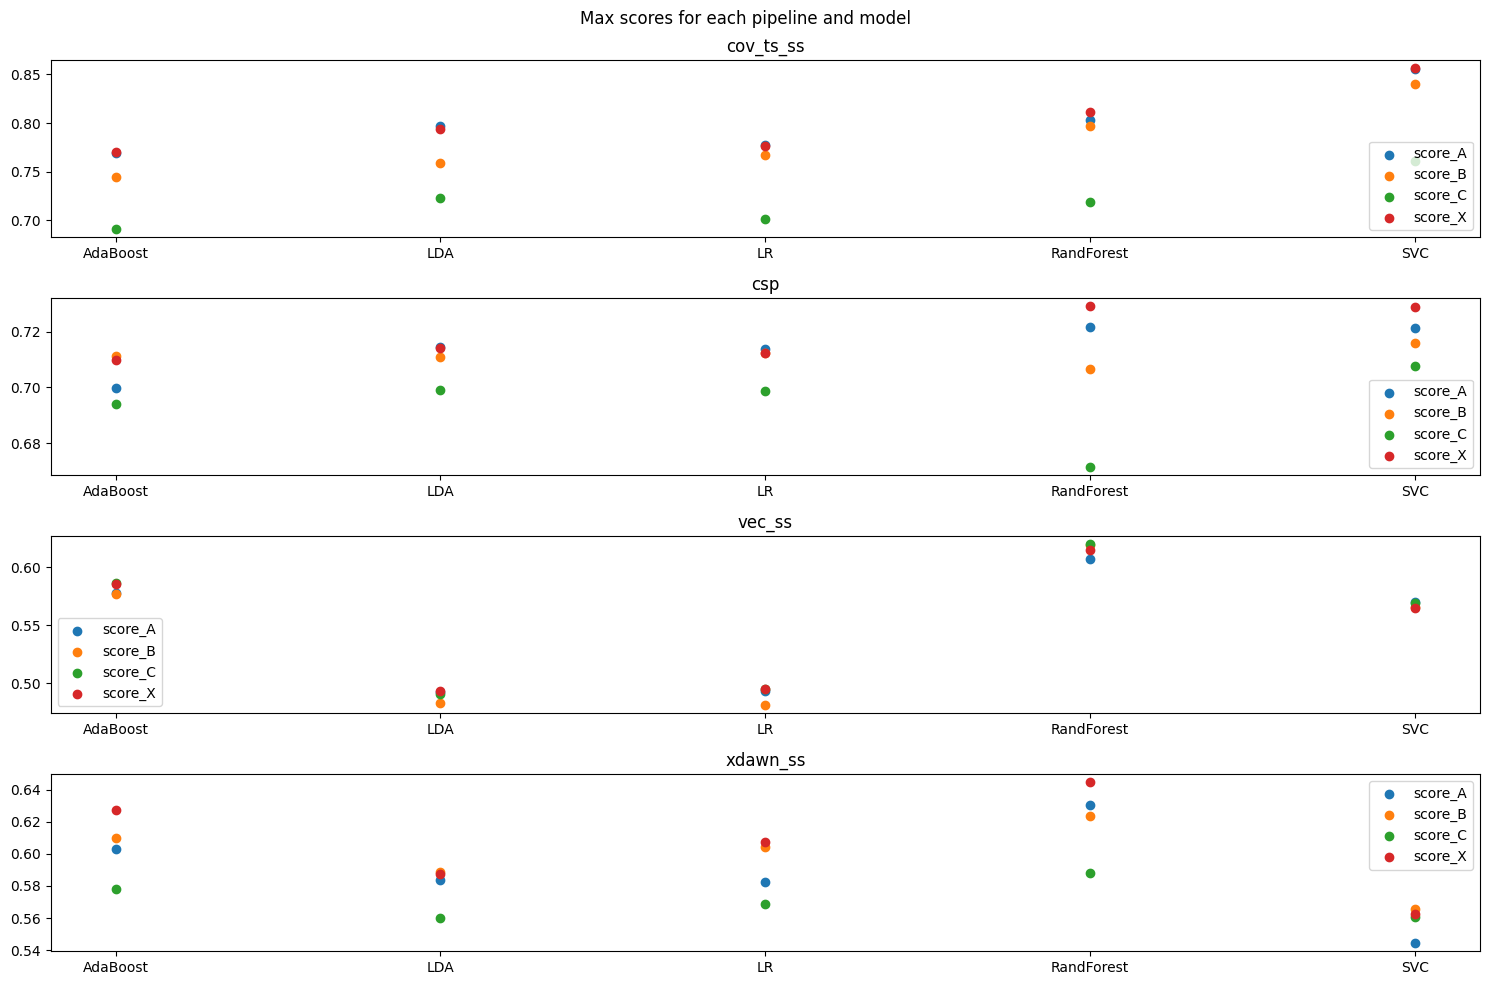

In [18]:
pipelines = result_df_v123['pipeline_name'].unique()
pipelines_df = [result_df_v123[result_df_v123['pipeline_name'] == p] for p in pipelines]

fig, ax = plt.subplots(len(pipelines), figsize=(15, 10))
for i, p in enumerate(pipelines):
    for j, score in enumerate(['score_A', 'score_B', 'score_C', 'score_X']):
        # get the max score for each model
        max_score = pipelines_df[i].groupby('model')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['model'], max_score[score], label=score, marker='o')
        ax[i].set_title(p)
        ax[i].legend()
fig.suptitle('Max scores for each pipeline and model')
plt.tight_layout()
plt.show()


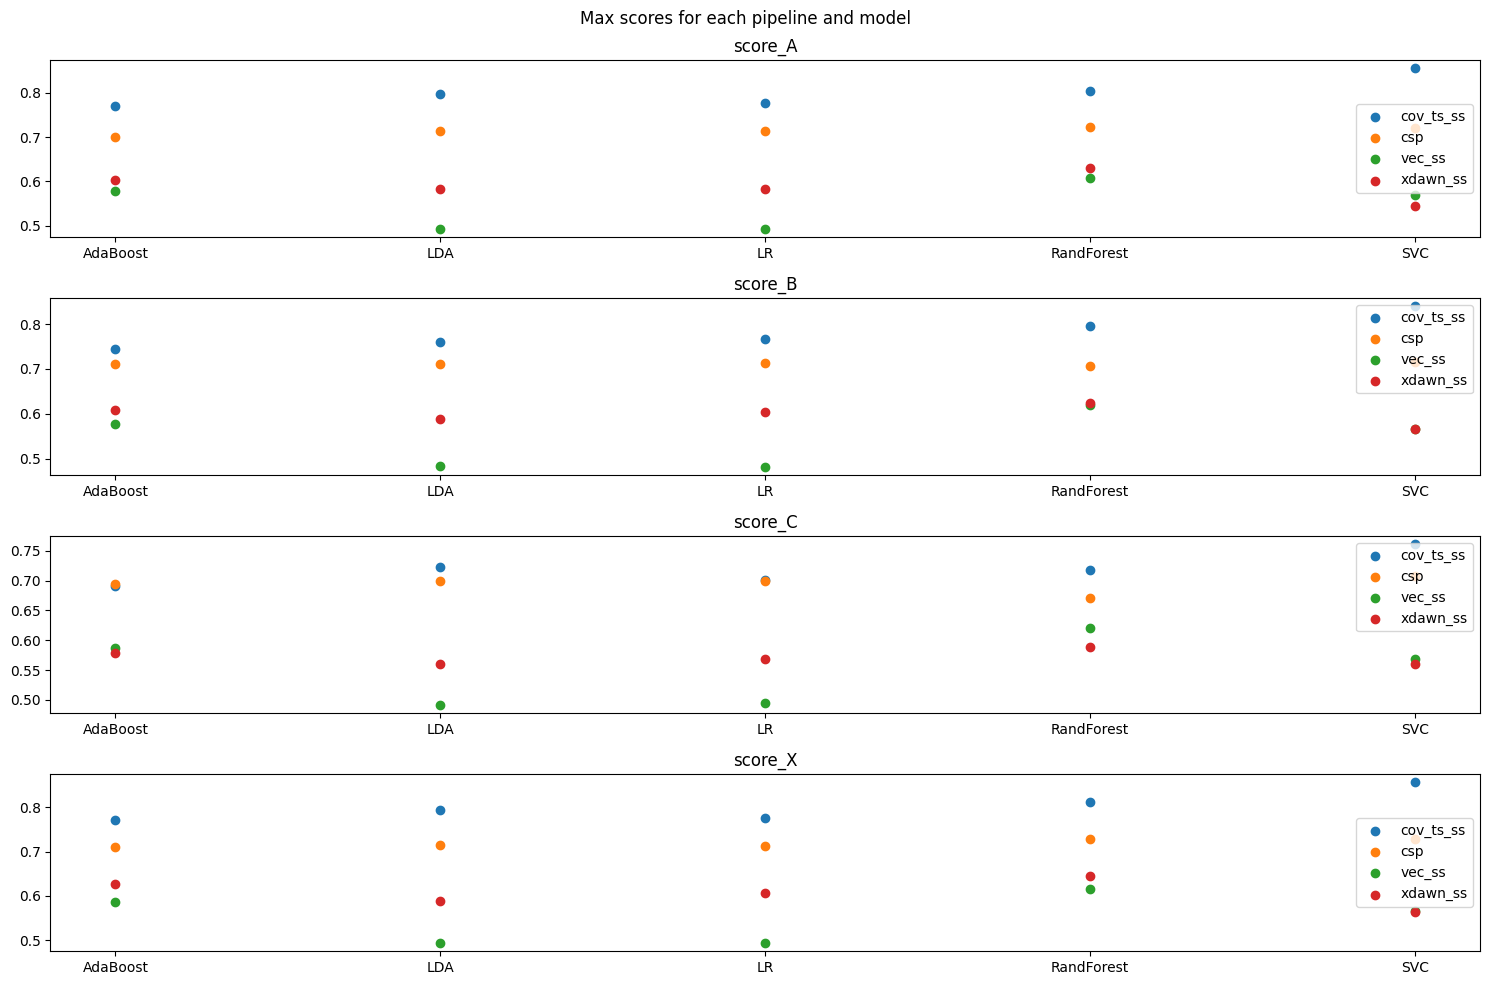

In [19]:
pipelines = result_df_v123['pipeline_name'].unique()
pipelines_df = [result_df_v123[result_df_v123['pipeline_name'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('model')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['model'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each pipeline and model')
plt.tight_layout()
plt.show()

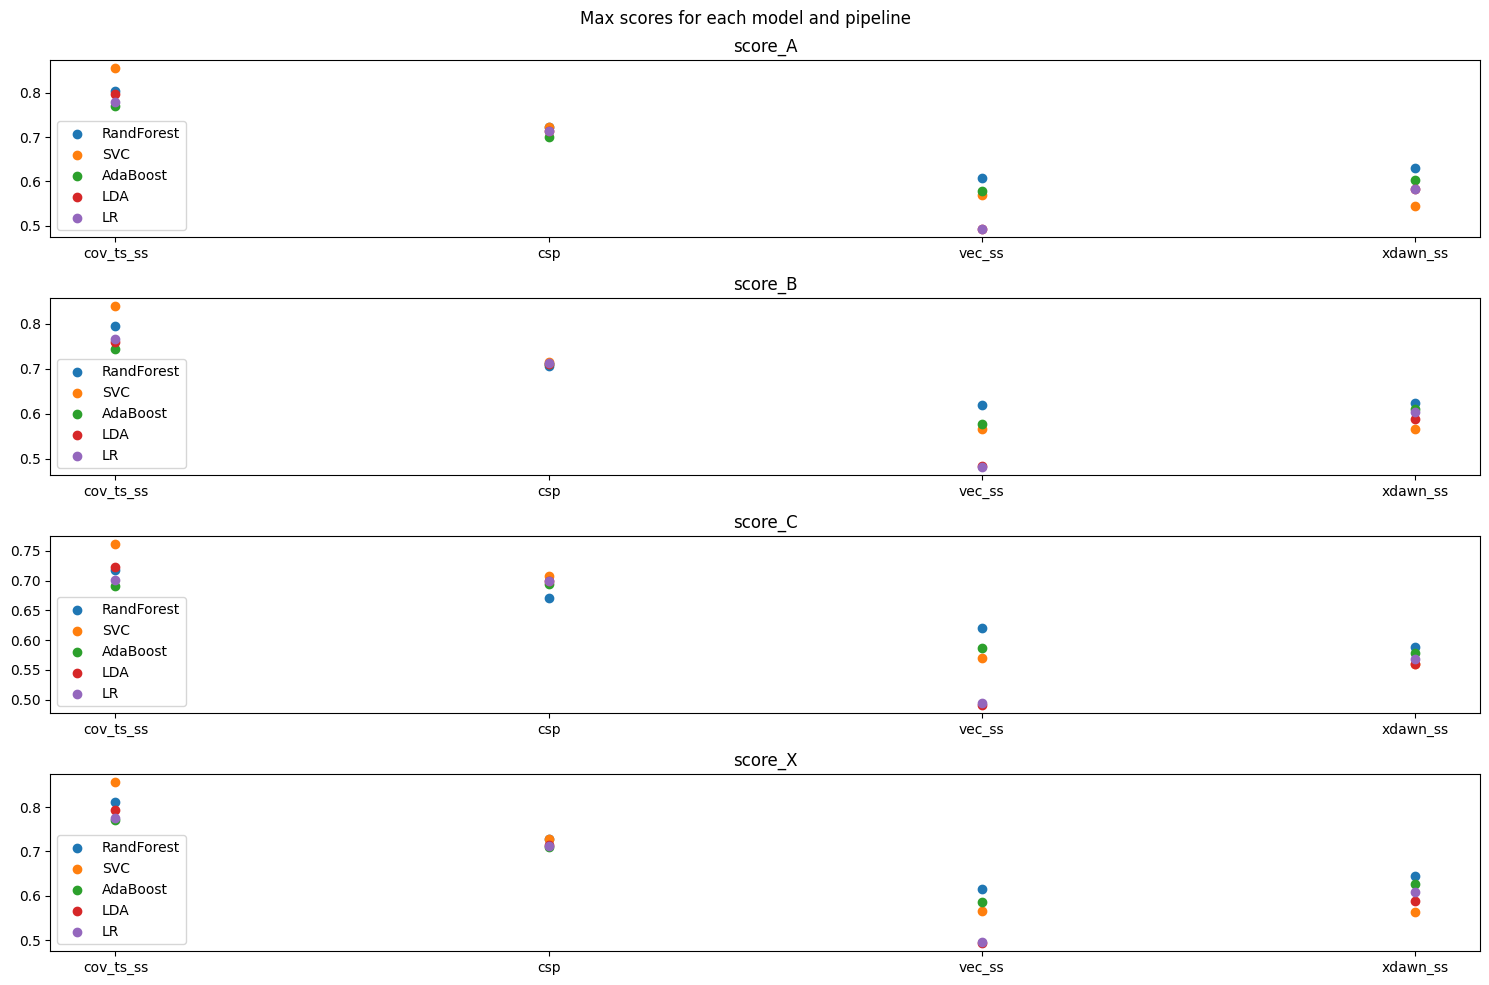

In [20]:
pipelines = result_df_v123['model'].unique()
pipelines_df = [result_df_v123[result_df_v123['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('pipeline_name')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each model and pipeline')
plt.tight_layout()
plt.show()

### Max results by score

In [21]:
# sort by score A
result_df = result_df_v123.sort_values(by='score_A', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,pipeline_name,model,pipeline_step_1,pipeline_step_2,pipeline_step_3,mean_score,mean_ABC,version
1,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,492.482502,294.445761,1885.156250,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,SVC,cov,ts,ss,0.828210,0.818763,v1
0,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.802722,0.796486,0.718391,0.811809,425.772692,304.968489,2542.937500,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,RandForest,cov,ts,ss,0.782352,0.772533,v1
4,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.796702,0.759258,0.722538,0.794200,689.888993,251.013045,1931.308594,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,LDA,cov,ts,ss,0.768174,0.759499,v1
14,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.777803,0.766749,0.700830,0.776437,633.932483,235.281698,1896.050781,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,LR,cov,ts,ss,0.755455,0.748461,v2
7,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.769006,0.744491,0.690972,0.770175,434.112629,401.044074,2540.964844,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,AdaBoost,cov,ts,ss,0.743661,0.734823,v1
9,-6,1.7,-0.75,30,9,"Pipeline(steps=[('csp',\r\n CS...",NaN,0.721612,0.706760,0.671404,0.729202,696.929935,457.677569,1929.636719,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,csp,RandForest,csp,no_step,no_step,0.707244,0.699925,v1
10,-6,1.7,-0.75,30,9,"Pipeline(steps=[('csp',\r\n CS...",NaN,0.721438,0.716039,0.707624,0.728944,675.296089,453.025419,2363.082031,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,csp,SVC,csp,no_step,no_step,0.718511,0.715034,v1
12,-6,1.7,-0.75,30,9,"Pipeline(steps=[('csp',\r\n CS...",NaN,0.714569,0.711081,0.699238,0.714135,421.941539,472.203167,2539.304688,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,csp,LDA,csp,no_step,no_step,0.709756,0.708296,v1
15,-6,1.7,-0.75,30,9,"Pipeline(steps=[('csp',\r\n CS...",NaN,0.713689,0.712253,0.698653,0.712243,497.699119,429.928265,1885.750000,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,csp,LR,csp,no_step,no_step,0.709210,0.708199,v2
2,-6,1.7,-0.75,30,9,"Pipeline(steps=[('csp',\r\n CS...",NaN,0.699833,0.711433,0.693997,0.709978,492.482502,440.696135,1755.011719,./../../../data/raw/Dat

In [22]:
# sort by score B
result_df = result_df_v123.sort_values(by='score_B', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,pipeline_name,model,pipeline_step_1,pipeline_step_2,pipeline_step_3,mean_score,mean_ABC,version
1,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,492.482502,294.445761,1885.156250,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,SVC,cov,ts,ss,0.828210,0.818763,v1
0,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.802722,0.796486,0.718391,0.811809,425.772692,304.968489,2542.937500,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,RandForest,cov,ts,ss,0.782352,0.772533,v1
14,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.777803,0.766749,0.700830,0.776437,633.932483,235.281698,1896.050781,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,LR,cov,ts,ss,0.755455,0.748461,v2


In [23]:
# sort by score C
result_df = result_df_v123.sort_values(by='score_C', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,pipeline_name,model,pipeline_step_1,pipeline_step_2,pipeline_step_3,mean_score,mean_ABC,version
1,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,492.482502,294.445761,1885.156250,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,SVC,cov,ts,ss,0.828210,0.818763,v1
4,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.796702,0.759258,0.722538,0.794200,689.888993,251.013045,1931.308594,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,LDA,cov,ts,ss,0.768174,0.759499,v1
0,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.802722,0.796486,0.718391,0.811809,425.772692,304.968489,2542.937500,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,RandForest,cov,ts,ss,0.782352,0.772533,v1


In [24]:
# sort mean of scores
result_df = result_df_v123.sort_values(by='mean_ABC', ascending=False)
result_df.head(5)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,pipeline_name,model,pipeline_step_1,pipeline_step_2,pipeline_step_3,mean_score,mean_ABC,version
1,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,492.482502,294.445761,1885.156250,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,SVC,cov,ts,ss,0.828210,0.818763,v1
0,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.802722,0.796486,0.718391,0.811809,425.772692,304.968489,2542.937500,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,RandForest,cov,ts,ss,0.782352,0.772533,v1
4,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.796702,0.759258,0.722538,0.794200,689.888993,251.013045,1931.308594,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,LDA,cov,ts,ss,0.768174,0.759499,v1
14,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.777803,0.766749,0.700830,0.776437,633.932483,235.281698,1896.050781,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,LR,cov,ts,ss,0.755455,0.748461,v2
7,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.769006,0.744491,0.690972,0.770175,434.112629,401.044074,2540.964844,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts_ss,AdaBoost,cov,ts,ss,0.743661,0.734823,v1


## Grid Search V6 : CSP, Riemann, Xdawn, Vec (=flatten), Wavelets, Bandpower on initial preprocessing (physically and intuition based) (movement prediction)

### Downloading the results

In [25]:
Version = 'V6'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v6 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save, verbose=True)
rebase_results(result_df_v6)
result_df_v6['version'] = 'v6'

Gathering 10 files
files: ['./../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_1.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_10.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_2.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_3.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_4.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_5.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_6.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_preproc_V6_node_7.csv', './../../src/training/many_pipelines_grid_search/results/V6/many_pipelines_MVT_search_prepro

### Prepocessing parameters grid

In [26]:
print_preproc(result_df_v6)

epochs_tmin: [-1]
epochs_length: [3]
epochs_empty_from_mvt_tmin: [-4]
epochs_intention_from_mvt_tmin: None
fmin: [1]
fmax: [40]


### Pipeline parameters grid

In [27]:
print_pipelines_params(result_df_v6)

pipeline_name: ['cov_ts' 'cov_ts_ss' 'bp' 'wvlt' 'wvlt_ss' 'cov_ss' 'csp_ss' 'csp'
 'bp_ss' 'cov']
model: ['SVC' 'LDA' 'RandForest' 'AdaBoost' 'LR' 'MLP']
pipeline_step_1: ['cov' 'bp' 'wavelet' 'csp']
pipeline_step_2: ['ts' 'no_step' 'ss' 'vec']
pipeline_step_3: ['no_step' 'ss' 'vec']


### Plots

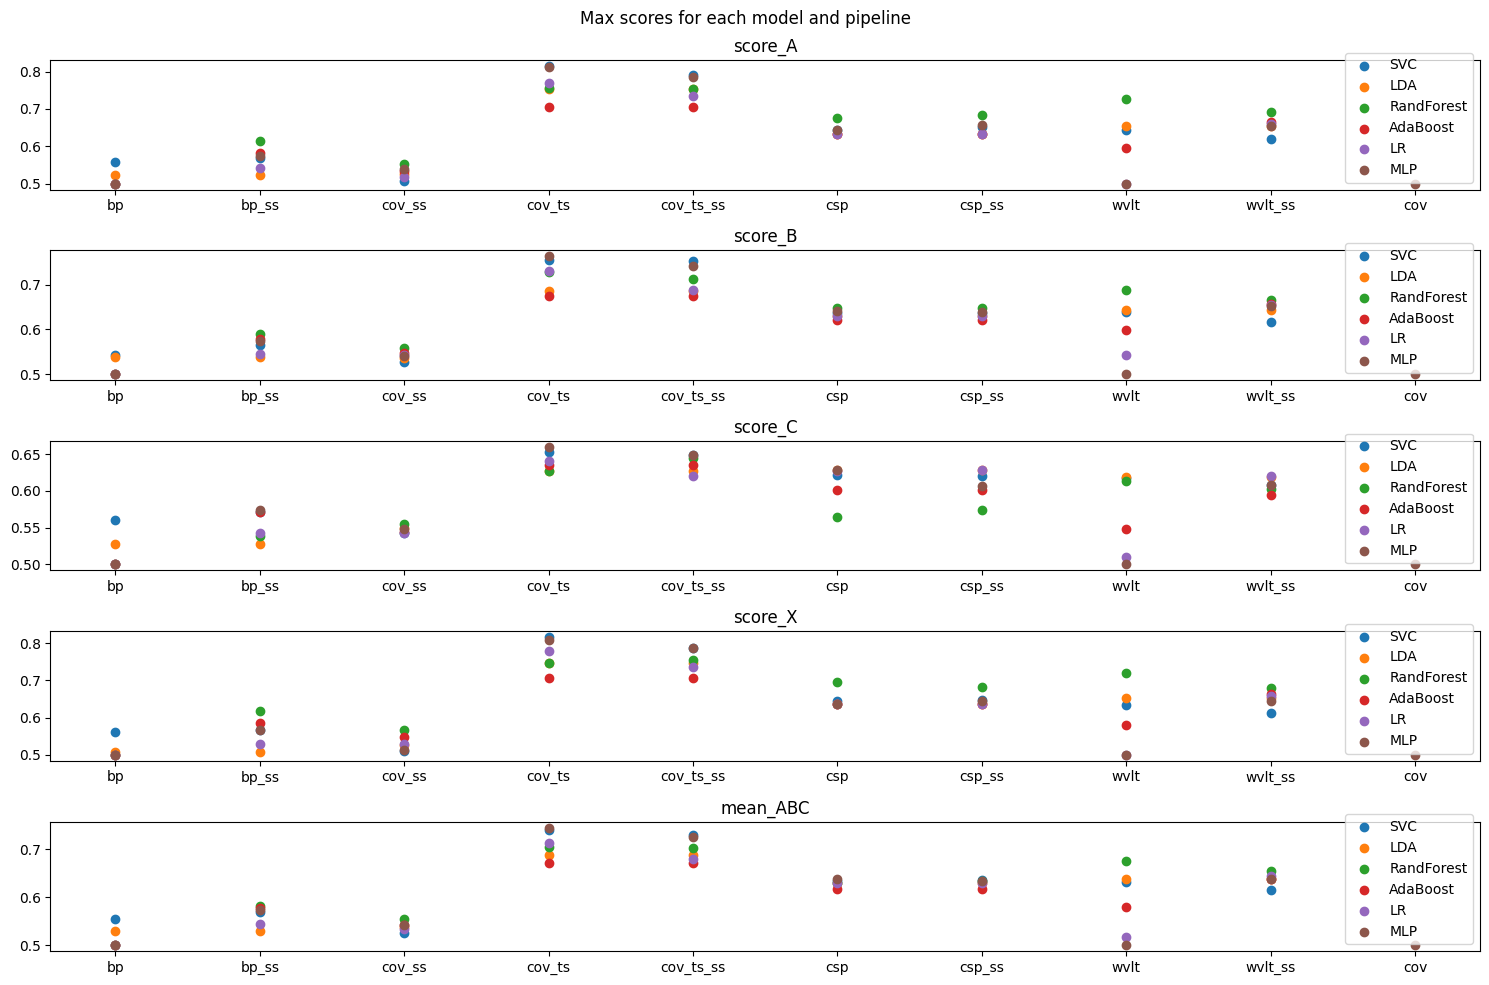

In [28]:
pipelines = result_df_v6['model'].unique()
pipelines_df = [result_df_v6[result_df_v6['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('pipeline_name')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each model and pipeline')
plt.tight_layout()
plt.show()

### Max scores

In [29]:
result_df_v6[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='mean_ABC', ascending=False).head(10)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_ABC
36,cov_ts,MLP,0.813282,0.763928,0.660164,0.807947,0.745792
0,cov_ts,SVC,0.815137,0.756114,0.653022,0.815864,0.741424
41,cov_ts_ss,SVC,0.789798,0.753801,0.649440,0.787774,0.731013
13,cov_ts_ss,MLP,0.786169,0.741680,0.648860,0.787252,0.725570
12,cov_ts,LR,0.770824,0.731734,0.640990,0.778867,0.714516
19,cov_ts,RandForest,0.755846,0.729903,0.627326,0.746842,0.704358
50,cov_ts_ss,RandForest,0.752988,0.713128,0.645092,0.754292,0.703736
31,cov_ts,LDA,0.752381,0.686732,0.626960,0.746127,0.688691
1,cov_ts_ss,LDA,0.752381,0.686732,0.626960,0.746127,0.688691
45,cov_ts_ss,LR,0.734472,0.687579,0.620016,0.735710,0.680689


In [30]:
result_df_v6[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='score_A', ascending=False).head(3)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_ABC
0,cov_ts,SVC,0.815137,0.756114,0.653022,0.815864,0.741424
36,cov_ts,MLP,0.813282,0.763928,0.660164,0.807947,0.745792
41,cov_ts_ss,SVC,0.789798,0.753801,0.649440,0.787774,0.731013


In [31]:
result_df_v6[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='score_B', ascending=False).head(3)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_ABC
36,cov_ts,MLP,0.813282,0.763928,0.660164,0.807947,0.745792
0,cov_ts,SVC,0.815137,0.756114,0.653022,0.815864,0.741424
41,cov_ts_ss,SVC,0.789798,0.753801,0.649440,0.787774,0.731013


In [32]:
result_df_v6[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='score_C', ascending=False).head(3)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_ABC
36,cov_ts,MLP,0.813282,0.763928,0.660164,0.807947,0.745792
0,cov_ts,SVC,0.815137,0.756114,0.653022,0.815864,0.741424
41,cov_ts_ss,SVC,0.789798,0.753801,0.649440,0.787774,0.731013


## Grid Search 7 : CSP, Riemann, Vec (=flatten), Wavelets, Bandpower on optimized preprocessing (movement prediction)

### Download the results

In [33]:
Version = 'V7'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v7 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save, verbose=True)
rebase_results(result_df_v7)
result_df_v7['version'] = 'v7'

Gathering 6 files
files: ['./../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_1.csv', './../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_2.csv', './../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_3.csv', './../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_4.csv', './../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_5.csv', './../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_6.csv']
File ./../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_1.csv has shape (9, 28)
File ./../../src/training/many_pipelines_grid_search/results/V7/many_pipelines_MVT_search_preproc_V7_node_2.csv has shape (9, 28)
File ./../../src/training/many_pipelines_grid_search/r

### Preprocessing parameters grid

In [34]:
print_preproc(result_df_v7)

epochs_tmin: [-0.75]
epochs_length: [1.7]
epochs_empty_from_mvt_tmin: [-6]
epochs_intention_from_mvt_tmin: None
fmin: [9]
fmax: [30]


### Pipeline parameters grid

In [35]:
print_pipelines_params(result_df_v7)

pipeline_name: ['cov_ts' 'cov_ts_ss' 'bp_ss' 'bp' 'wvlt' 'wvlt_ss' 'cov_ss' 'csp'
 'csp_ss' 'cov']
model: ['SVC' 'LR' 'RandForest' 'AdaBoost' 'LDA' 'MLP']
pipeline_step_1: ['cov' 'bp' 'wavelet' 'csp']
pipeline_step_2: ['ts' 'ss' 'no_step' 'vec']
pipeline_step_3: ['no_step' 'ss' 'vec']


### Plots

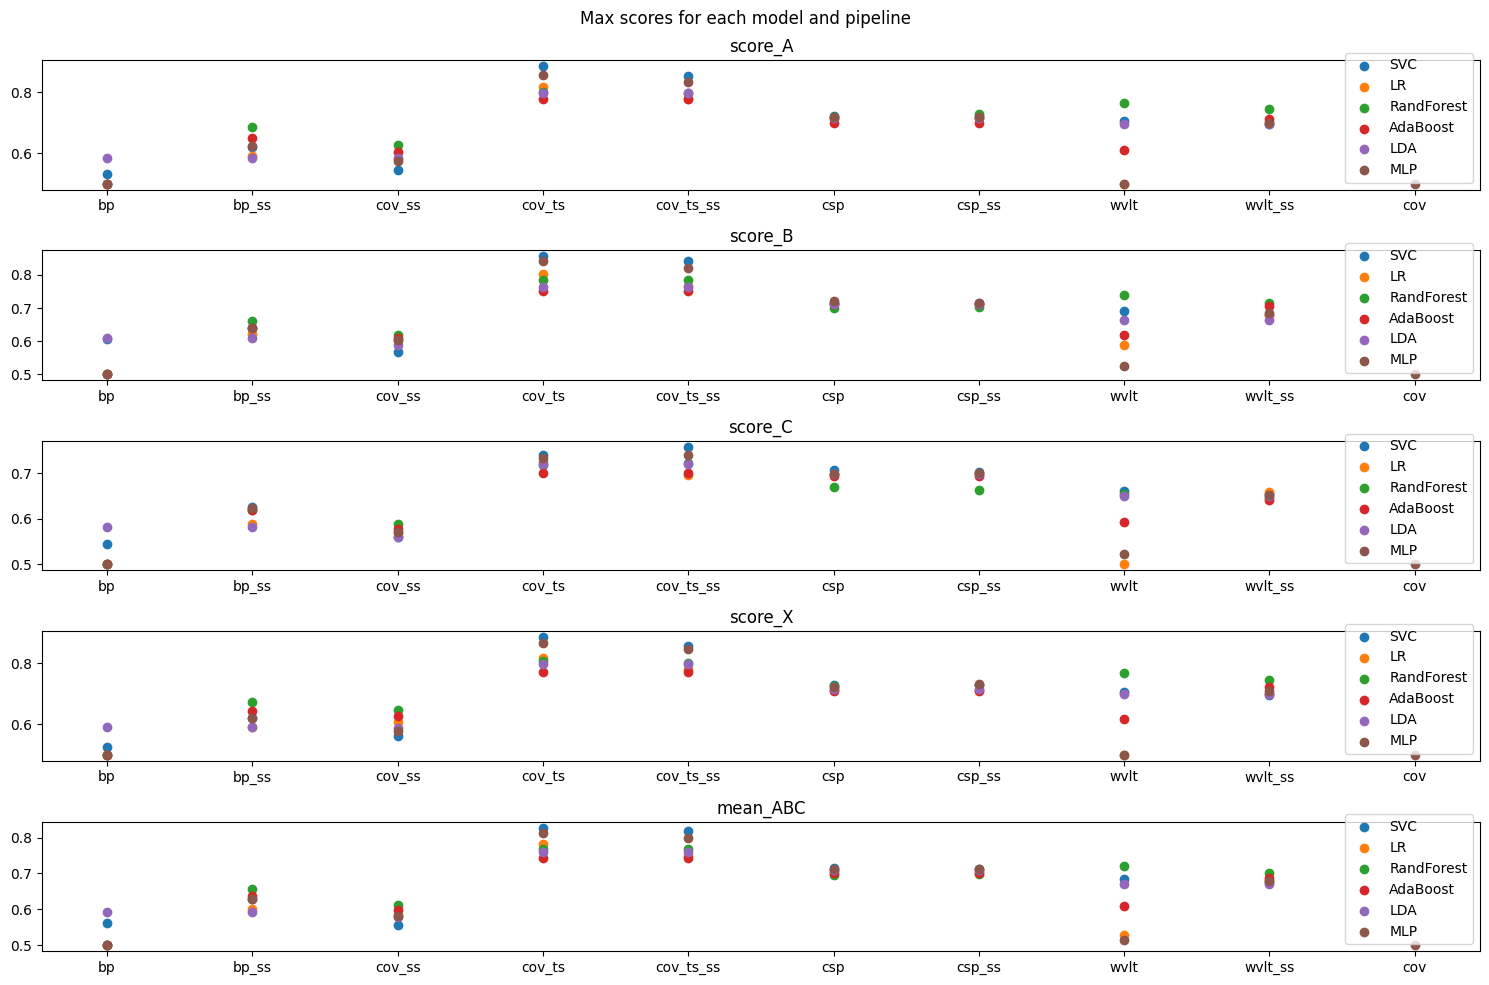

In [36]:
pipelines = result_df_v7['model'].unique()
pipelines_df = [result_df_v7[result_df_v7['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('pipeline_name')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each model and pipeline')
plt.tight_layout()
plt.show()

In [37]:
result_df_v7.sort_values(by='mean_ABC', ascending=False).head(1)


,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,pipeline_name,model,pipeline_step_1,pipeline_step_2,pipeline_step_3,mean_score,mean_ABC,version
0,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",0.886628,0.856416,0.740754,0.884521,426.357866,214.7638,2594.359375,./../../../data/raw/Data_npy/,-1,42,4,True,7,./results/,many_pipelines_MVT_search_preproc,./data/processed/,/iterations/,many_pipelines_MVT_search_preproc_iter,./logs/,True,True,True,cov_ts,SVC,cov,ts,no_step,0.84208,0.827933,v7


### Max scores

In [38]:
result_df_v7[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='mean_ABC', ascending=False).head(10)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_ABC
0,cov_ts,SVC,0.886628,0.856416,0.740754,0.884521,0.827933
1,cov_ts_ss,SVC,0.852283,0.841630,0.758440,0.854708,0.817451
45,cov_ts,MLP,0.858168,0.842658,0.734125,0.865205,0.811651
46,cov_ts_ss,MLP,0.833440,0.819896,0.739444,0.845475,0.797593
9,cov_ts,LR,0.817072,0.803625,0.725542,0.814998,0.782080
19,cov_ts_ss,RandForest,0.797643,0.785670,0.723162,0.801465,0.768825
18,cov_ts,RandForest,0.800942,0.784857,0.717285,0.805480,0.767694
37,cov_ts_ss,LDA,0.797630,0.762747,0.720473,0.796000,0.760283
36,cov_ts,LDA,0.797630,0.762747,0.720473,0.796000,0.760283
10,cov_ts_ss,LR,0.778871,0.767908,0.696089,0.781573,0.747623


In [39]:
result_df_v7[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_score']].sort_values(by='score_A', ascending=False).head(3)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_score
0,cov_ts,SVC,0.886628,0.856416,0.740754,0.884521,0.842080
45,cov_ts,MLP,0.858168,0.842658,0.734125,0.865205,0.825039
1,cov_ts_ss,SVC,0.852283,0.841630,0.758440,0.854708,0.826765


In [40]:
result_df_v7[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_score']].sort_values(by='score_B', ascending=False).head(3)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_score
0,cov_ts,SVC,0.886628,0.856416,0.740754,0.884521,0.842080
45,cov_ts,MLP,0.858168,0.842658,0.734125,0.865205,0.825039
1,cov_ts_ss,SVC,0.852283,0.841630,0.758440,0.854708,0.826765


In [41]:
result_df_v7[['pipeline_name', 'model', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_score']].sort_values(by='score_C', ascending=False).head(3)

,pipeline_name,model,score_A,score_B,score_C,score_X,mean_score
1,cov_ts_ss,SVC,0.852283,0.841630,0.758440,0.854708,0.826765
0,cov_ts,SVC,0.886628,0.856416,0.740754,0.884521,0.842080
46,cov_ts_ss,MLP,0.833440,0.819896,0.739444,0.845475,0.809564


### Concatenate the results V6 and V7 (Comparing preprocessing Initial (I) vs Optimized (O))

The preprocessing initial is the one that was first tested when mocking up our first pipelines. 
The optimized preprocessing is the one that was optimized in the first grid search on Riemanian geometry. (Covariance -> Riemann -> standard Scaler -> SVM)

This comparison will allow us to see if the optimized preprocessing is really better than the initial onne on many pipelines.

#### Concatenating the results

In [42]:
result_df_v7['preproc_pipeline_name'] = result_df_v7['pipeline_name'].apply(lambda x: f'O\n{x}')
#result_df_v6 = pd.read_csv(SAVE_PATH + NAME_SAVE + "_V6.csv")
#rebase_results(result_df_v6)
result_df_v6['preproc_pipeline_name'] = result_df_v6['pipeline_name'].apply(lambda x: f'I\n{x}')
result_df_v67 = pd.concat([result_df_v6, result_df_v7], ignore_index=True)
result_df_v67 = result_df_v67.sort_values(by=['model'])

#### Plots

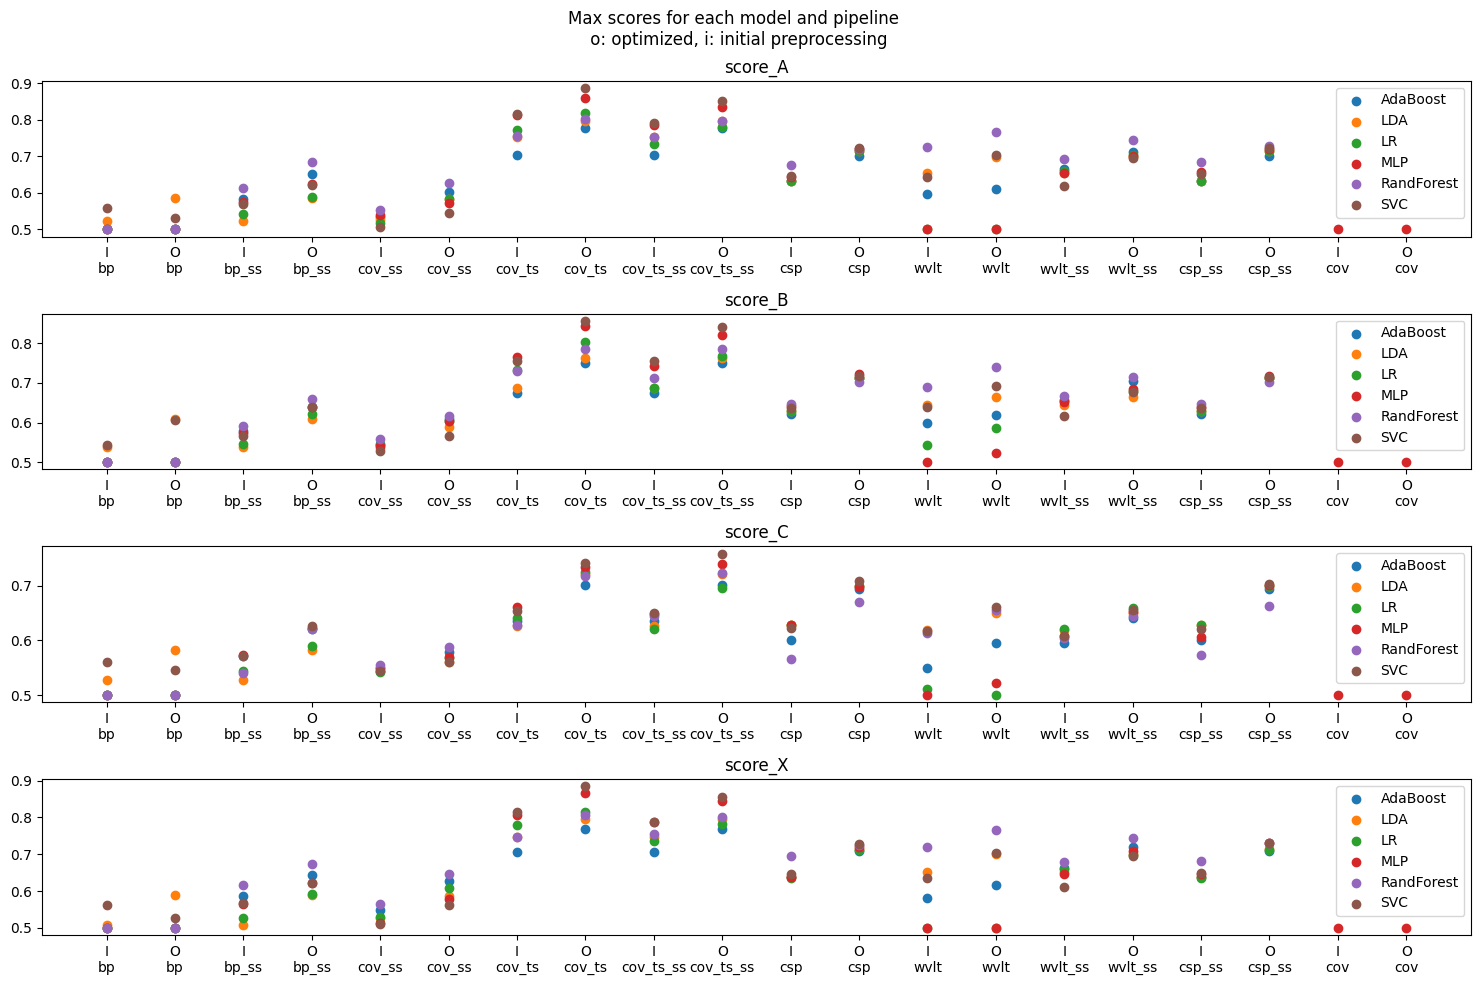

In [43]:
result_df_v67 = result_df_v67.sort_values(by=['model'], ascending=True)
pipelines = result_df_v67['model'].unique()
pipelines_df = [result_df_v67[result_df_v67['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X']


fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('preproc_pipeline_name')[score].max()
        max_score = max_score.reset_index()
        max_score['preproc'] = max_score['preproc_pipeline_name'].apply(lambda x: x.split('\n')[0])
        max_score['pipeline_name'] = max_score['preproc_pipeline_name'].apply(lambda x: x.split('\n')[1])
        max_score['custom_order'] = max_score['pipeline_name'].apply(lambda x: 1 if x=='csp_ss' else 0)
        max_score = max_score.sort_values(by=['custom_order', 'pipeline_name', 'preproc'], ascending=True)
        ax[i].scatter(max_score['preproc_pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
        
fig.suptitle('Max scores for each model and pipeline \n o: optimized, i: initial preprocessing')
plt.tight_layout()
plt.show()

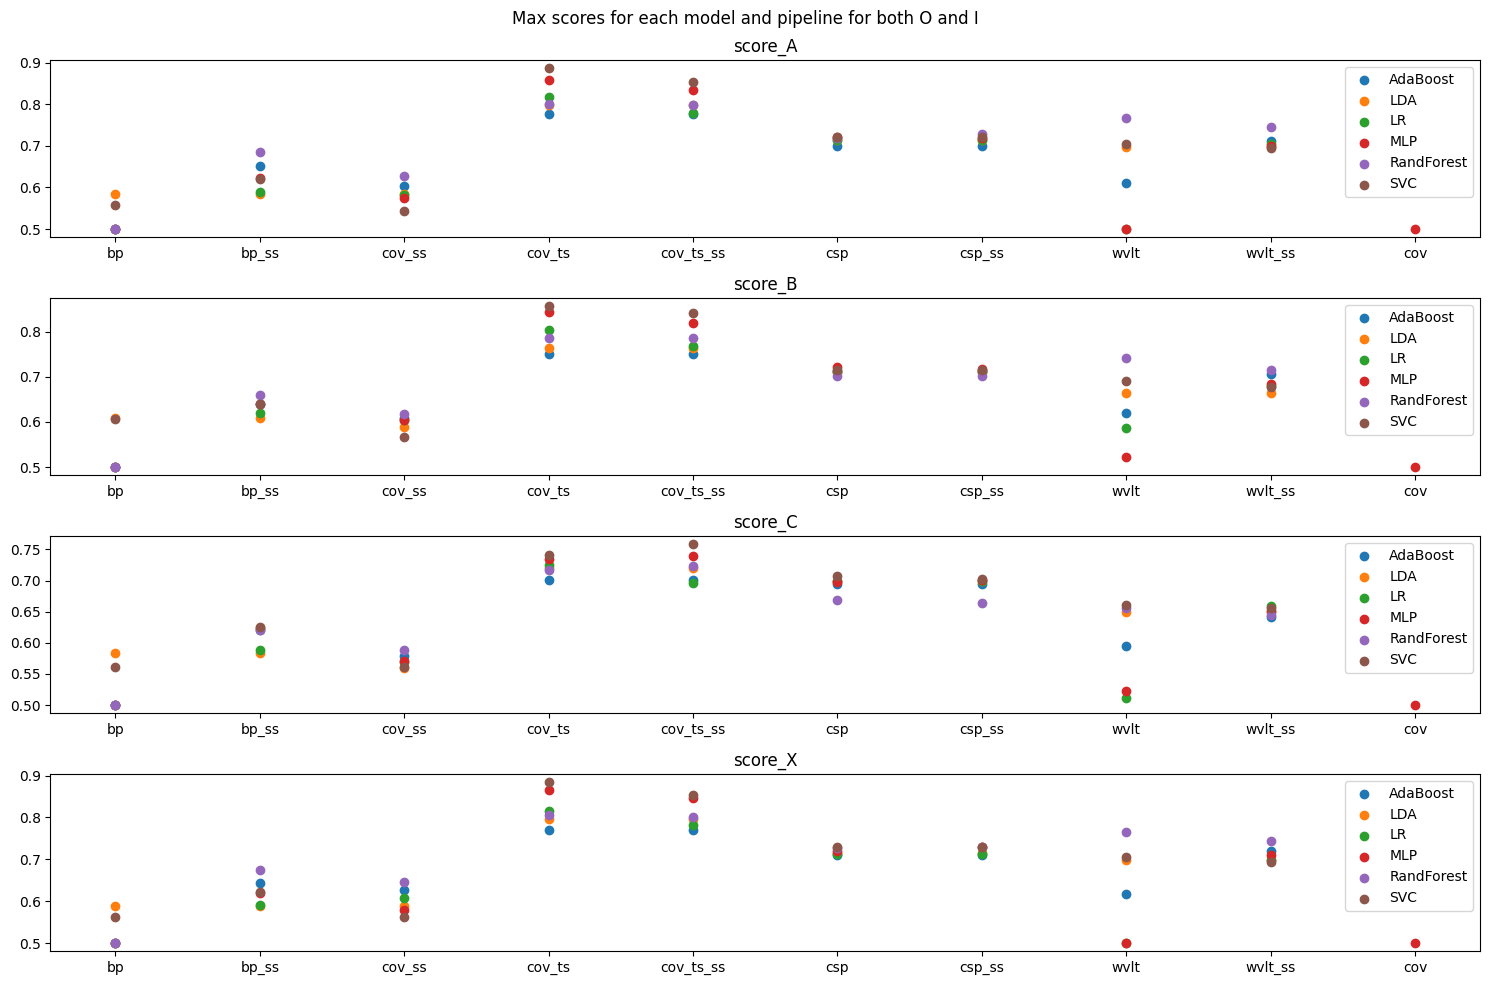

In [44]:
pipelines = result_df_v67['model'].unique()
pipelines_df = [result_df_v67[result_df_v67['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('pipeline_name')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each model and pipeline for both O and I')
plt.tight_layout()
plt.show()

In [45]:
result_df_v67.columns

Index(['EPOCHS_EMPTY_FROM_MVT_TMIN', 'EPOCHS_LENGTH', 'EPOCHS_TMIN', 'FMAX',
       'FMIN', 'pipeline', 'score_A', 'score_B', 'score_C', 'score_X',
       'duration_preprocessing', 'duration_train', 'memory', 'FILE_PATH',
       'NUMBER_OF_SESSIONS', 'RANDOM_STATE', 'N_SPLIT',
       'BINARY_CLASSIFICATION', 'VERSION', 'PATH_RESULTS', 'NAME_RESULTS',
       'PATH_DATA_PROCESSED', 'FOLDER_RESULTS_ITERATIONS',
       'NAME_RESULTS_ITERATIONS', 'LOG_FOLDER', 'SAVE_EACH_ITERATION',
       'REMOVE_ITERATIONS', 'REMOVE_DATA_PROCESSED', 'pipeline_name', 'model',
       'pipeline_step_1', 'pipeline_step_2', 'pipeline_step_3', 'mean_score',
       'mean_ABC', 'version', 'preproc_pipeline_name'],
      dtype='object')

#### Max scores

In [46]:
result_df_v67['preproc'] = result_df_v67['preproc_pipeline_name'].apply(lambda x: x.split('\n')[0])

In [47]:
result_df_v67[['pipeline_name', 'model', 'preproc', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='mean_ABC', ascending=False).head(10)

,pipeline_name,model,preproc,score_A,score_B,score_C,score_X,mean_ABC
55,cov_ts,SVC,O,0.886628,0.856416,0.740754,0.884521,0.827933
56,cov_ts_ss,SVC,O,0.852283,0.841630,0.758440,0.854708,0.817451
100,cov_ts,MLP,O,0.858168,0.842658,0.734125,0.865205,0.811651
101,cov_ts_ss,MLP,O,0.833440,0.819896,0.739444,0.845475,0.797593
64,cov_ts,LR,O,0.817072,0.803625,0.725542,0.814998,0.782080
74,cov_ts_ss,RandForest,O,0.797643,0.785670,0.723162,0.801465,0.768825
73,cov_ts,RandForest,O,0.800942,0.784857,0.717285,0.805480,0.767694
92,cov_ts_ss,LDA,O,0.797630,0.762747,0.720473,0.796000,0.760283
91,cov_ts,LDA,O,0.797630,0.762747,0.720473,0.796000,0.760283
65,cov_ts_ss,LR,O,0.778871,0.767908,0.696089,0.781573,0.747623


In [48]:
result_df_v67[['pipeline_name', 'model', 'preproc', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='score_A', ascending=False).head(3)

,pipeline_name,model,preproc,score_A,score_B,score_C,score_X,mean_ABC
55,cov_ts,SVC,O,0.886628,0.856416,0.740754,0.884521,0.827933
100,cov_ts,MLP,O,0.858168,0.842658,0.734125,0.865205,0.811651
56,cov_ts_ss,SVC,O,0.852283,0.841630,0.758440,0.854708,0.817451


In [49]:
result_df_v67[['pipeline_name', 'model', 'preproc', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='score_B', ascending=False).head(3)

,pipeline_name,model,preproc,score_A,score_B,score_C,score_X,mean_ABC
55,cov_ts,SVC,O,0.886628,0.856416,0.740754,0.884521,0.827933
100,cov_ts,MLP,O,0.858168,0.842658,0.734125,0.865205,0.811651
56,cov_ts_ss,SVC,O,0.852283,0.841630,0.758440,0.854708,0.817451


In [50]:
result_df_v67[['pipeline_name', 'model', 'preproc', 'score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']].sort_values(by='score_C', ascending=False).head(3)

,pipeline_name,model,preproc,score_A,score_B,score_C,score_X,mean_ABC
56,cov_ts_ss,SVC,O,0.852283,0.841630,0.758440,0.854708,0.817451
55,cov_ts,SVC,O,0.886628,0.856416,0.740754,0.884521,0.827933
101,cov_ts_ss,MLP,O,0.833440,0.819896,0.739444,0.845475,0.797593


### Concatenate V1, V2, V3, V7 (optimized preprocessing)

#### Concatenating the results

In [51]:
result_df_v1237 = pd.concat([result_df_v123, result_df_v7], ignore_index=True)

#### Plots

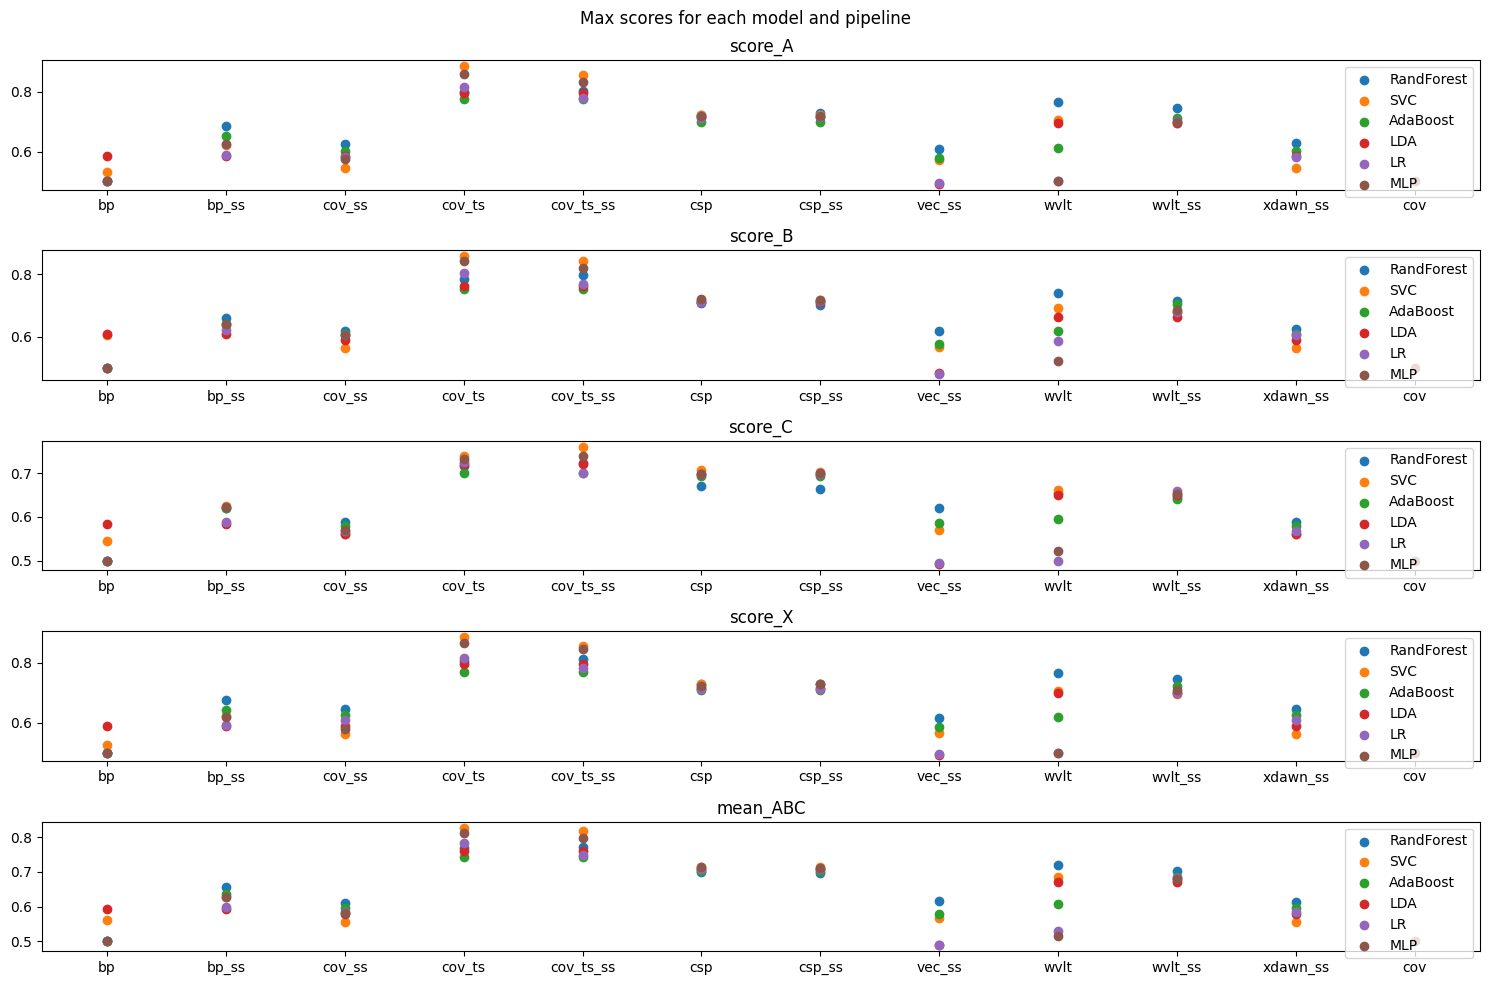

In [52]:
pipelines = result_df_v1237['model'].unique()
pipelines_df = [result_df_v1237[result_df_v1237['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('pipeline_name')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each model and pipeline')
plt.tight_layout()
plt.show()

## Grid Search 8 : CSP, Riemann, Vec (=flatten), Wavelets, Bandpower on based preprocessing (movement intention prediction)

### Downloading the results

In [53]:
Version = 'V8'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v8 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save, verbose=True)
result_df_v8['version'] = Version
rebase_results(result_df_v8)

Gathering 6 files
files: ['./../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_1.csv', './../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_2.csv', './../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_3.csv', './../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_4.csv', './../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_5.csv', './../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_6.csv']
File ./../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_1.csv has shape (9, 29)
File ./../../src/training/many_pipelines_grid_search/results/V8/many_pipelines_MVT_search_preproc_V8_node_2.csv has shape (9, 29)
File ./../../src/training/many_pipelines_grid_search/r

### Preprocessing parameters grid

In [54]:
print_preproc(result_df_v8)

epochs_tmin: [0]
epochs_length: [2]
epochs_empty_from_mvt_tmin: [-6]
epochs_intention_from_mvt_tmin: [-2]
fmin: [9]
fmax: [30]


### Pipeline parameters grid

In [55]:
print_pipelines_params(result_df_v8)

pipeline_name: ['cov_ts' 'cov_ts_ss' 'bp_ss' 'bp' 'wvlt' 'wvlt_ss' 'cov_ss' 'csp'
 'csp_ss' 'cov']
model: ['SVC' 'LR' 'RandForest' 'AdaBoost' 'LDA' 'MLP']
pipeline_step_1: ['cov' 'bp' 'wavelet' 'csp']
pipeline_step_2: ['ts' 'ss' 'no_step' 'vec']
pipeline_step_3: ['no_step' 'ss' 'vec']


### Max scores

In [56]:
# display all columns
pd.set_option('display.max_columns', None)
result_df_v8[['pipeline_name', 'pipeline_step_1', 'pipeline_step_2', 'pipeline_step_3', 'model', 'mean_ABC', 'score_A', 'score_B', 'score_C', 'score_X']].sort_values(by='mean_ABC', ascending=False).head(10)

,pipeline_name,pipeline_step_1,pipeline_step_2,pipeline_step_3,model,mean_ABC,score_A,score_B,score_C,score_X
45,cov_ts,cov,ts,vec,MLP,0.566888,0.576820,0.579878,0.543965,0.582461
50,wvlt_ss,wavelet,ss,vec,MLP,0.565466,0.574247,0.559130,0.563021,0.558597
46,cov_ts_ss,cov,ts,ss,MLP,0.560055,0.575211,0.563476,0.541478,0.567867
9,cov_ts,cov,ts,no_step,LR,0.557560,0.556394,0.564684,0.551601,0.554677
10,cov_ts_ss,cov,ts,ss,LR,0.555429,0.555659,0.559861,0.550767,0.550817
14,wvlt_ss,wavelet,ss,no_step,LR,0.554888,0.554132,0.558534,0.551998,0.563741
37,cov_ts_ss,cov,ts,ss,LDA,0.554010,0.552396,0.559451,0.550185,0.556079
36,cov_ts,cov,ts,no_step,LDA,0.554010,0.552396,0.559451,0.550185,0.556079
41,wvlt_ss,wavelet,ss,no_step,LDA,0.550039,0.551746,0.551396,0.546974,0.558338
40,wvlt,wavelet,no_step,no_step,LDA,0.550039,0.551746,0.551396,0.546974,0.558338


In [57]:
result_df_v8[['pipeline_name', 'pipeline_step_1', 'pipeline_step_2', 'pipeline_step_3', 'model', 'mean_ABC', 'score_A', 'score_B', 'score_C', 'score_X']].sort_values(by='score_A', ascending=False).head(3)

,pipeline_name,pipeline_step_1,pipeline_step_2,pipeline_step_3,model,mean_ABC,score_A,score_B,score_C,score_X
45,cov_ts,cov,ts,vec,MLP,0.566888,0.576820,0.579878,0.543965,0.582461
46,cov_ts_ss,cov,ts,ss,MLP,0.560055,0.575211,0.563476,0.541478,0.567867
50,wvlt_ss,wavelet,ss,vec,MLP,0.565466,0.574247,0.559130,0.563021,0.558597


In [58]:
result_df_v8[['pipeline_name', 'pipeline_step_1', 'pipeline_step_2', 'pipeline_step_3', 'model', 'mean_ABC', 'score_A', 'score_B', 'score_C', 'score_X']].sort_values(by='score_B', ascending=False).head(3)

,pipeline_name,pipeline_step_1,pipeline_step_2,pipeline_step_3,model,mean_ABC,score_A,score_B,score_C,score_X
45,cov_ts,cov,ts,vec,MLP,0.566888,0.576820,0.579878,0.543965,0.582461
9,cov_ts,cov,ts,no_step,LR,0.557560,0.556394,0.564684,0.551601,0.554677
46,cov_ts_ss,cov,ts,ss,MLP,0.560055,0.575211,0.563476,0.541478,0.567867


In [59]:
result_df_v8[['pipeline_name', 'pipeline_step_1', 'pipeline_step_2', 'pipeline_step_3', 'model', 'mean_ABC', 'score_A', 'score_B', 'score_C', 'score_X']].sort_values(by='score_C', ascending=False).head(3)

,pipeline_name,pipeline_step_1,pipeline_step_2,pipeline_step_3,model,mean_ABC,score_A,score_B,score_C,score_X
50,wvlt_ss,wavelet,ss,vec,MLP,0.565466,0.574247,0.559130,0.563021,0.558597
14,wvlt_ss,wavelet,ss,no_step,LR,0.554888,0.554132,0.558534,0.551998,0.563741
9,cov_ts,cov,ts,no_step,LR,0.557560,0.556394,0.564684,0.551601,0.554677


### Plots

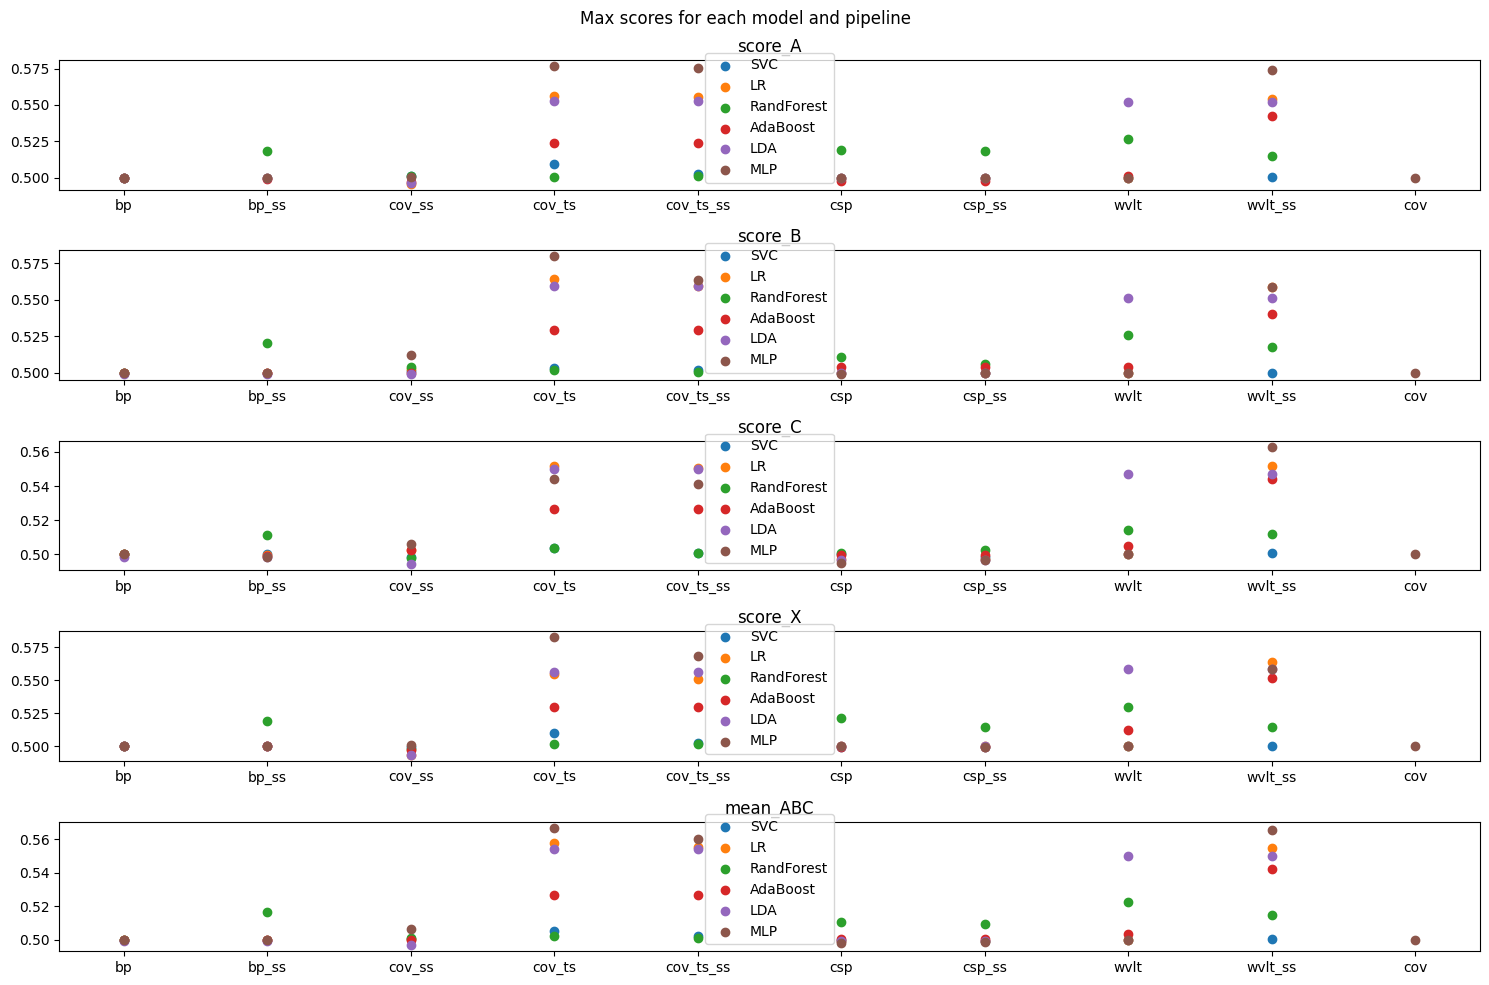

In [60]:
pipelines = result_df_v8['model'].unique()
pipelines_df = [result_df_v8[result_df_v8['model'] == p] for p in pipelines]
scores = ['score_A', 'score_B', 'score_C', 'score_X', 'mean_ABC']

fig, ax = plt.subplots(len(scores), figsize=(15, 10))
for i, score in enumerate(scores):
    for j, p in enumerate(pipelines):
        # get the max score for each model
        max_score = pipelines_df[j].groupby('pipeline_name')[score].max()
        max_score = max_score.reset_index()
        ax[i].scatter(max_score['pipeline_name'], max_score[score], label=p, marker='o')
        ax[i].set_title(score)
        ax[i].legend()
fig.suptitle('Max scores for each model and pipeline')
plt.tight_layout()
plt.show()